<a href="https://colab.research.google.com/github/coviseg/Baselines/blob/master/ResNet50%20Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import h5py
import os

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
!git clone https://github.com/coviseg/Baselines
% cd Baselines
clear_output()

# Data

I will get the data from the [UCSD covid repo](https://github.com/UCSD-AI4H/COVID-CT) from CT with COVID pacients and non COVID pacients.

In [4]:
!wget https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip?raw=true
!unzip CT_COVID.zip?raw=true
!wget https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_NonCOVID.zip?raw=true
!unzip CT_NonCOVID.zip?raw=true
clear_output()

covid_dir = "CT_COVID/"
noncovid_dir = "CT_NonCOVID/"

assert os.listdir(covid_dir) != [], "Data for the covid directory not imported"
assert os.listdir(noncovid_dir) != [], "Data for the noncovid directory not imported"
print("Everything Worked!")

Everything Worked!


Data pipeline is adapted from the [keras.io examples](https://keras.io/examples/vision/oxford_pets_image_segmentation/)

In [6]:
import utils.data as data

# covid_dir = "CT_COVID/"
# noncovid_dir = "CT_NonCOVID/"

img_size = (160, 160)

img_paths_covid = data.get_paths(covid_dir)
img_paths_noncovid = data.get_paths(noncovid_dir)


print(f"Number of samples with COVID: {len(img_paths_covid)}")
print(f"Number of samples without COVID: {len(img_paths_noncovid)}")

# Merging all data
all_paths = img_paths_covid + img_paths_noncovid
print(f"Number of total samples: {len(all_paths)}")

Number of samples with COVID: 349
Number of samples without COVID: 195
Number of total samples: 544


Let's show an example

## With covid

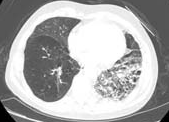

## Without covid

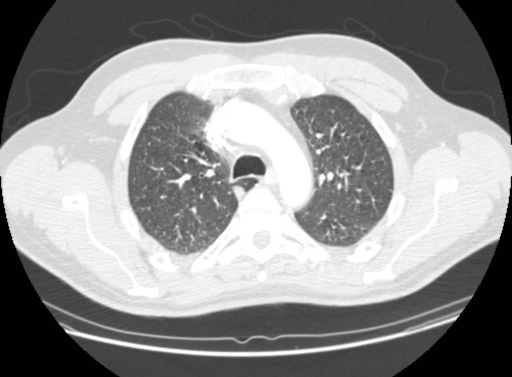

In [7]:
from IPython.display import Image, display, Markdown
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

index = 80
display(Markdown('## With covid'))
display(Image(filename=img_paths_covid[index]))

display(Markdown('## Without covid'))
display(Image(filename=img_paths_noncovid[index]))

In [19]:
# Split our img paths into a training and a validation set
batch_size = 32
# I'll do this in order to match the output of the prediction
times_batchsize = 3

train_paths, val_paths = data.generate_train_test(all_paths, 
                                             batch_size, 
                                             times_batchsize)

# Instantiate data Sequences for each split
train_gen = data.Covid(batch_size, img_size, train_paths)
val_gen = data.Covid(batch_size, img_size, val_paths)

print(f"Validation Split: {np.round(len(val_paths)/len(all_paths),3)}")

Validation Split: 0.176


## Model

In [15]:
# ResNet Model
def resnet(img_size):
  """ Creates a resnet50 keras model for binary classification.

  Parameters:
    img_size (tuple): Tuple with the images dimensions that we feed to the model

  Output:
    (tf.keras.Model): resnet50 model
  """
  res_net = tf.keras.applications.ResNet50(input_shape = img_size + (3,), include_top = False)  
  flat = tf.keras.layers.Flatten()(res_net.output)
  y_hat = tf.keras.layers.Dense(1, activation = "sigmoid")(flat)
  return tf.keras.models.Model(res_net.input, y_hat)

model = resnet(img_size)

# Make Only top layers trainable
for layers in model.layers[:-22]:
    layers.trainable= False

### compiling model

In [16]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", 
              metrics = ["accuracy"])

## Training

In [17]:
epochs = 10
history = model.fit(train_gen,
                validation_data=val_gen, 
                epochs=epochs)

Epoch 1/10
14/14 [==============================] - 4s 262ms/step - loss: 2.7072 - accuracy: 0.6295 - val_loss: 5.8209 - val_accuracy: 0.6354
Epoch 2/10
14/14 [==============================] - 3s 192ms/step - loss: 0.5244 - accuracy: 0.8080 - val_loss: 6.1612 - val_accuracy: 0.6458
Epoch 3/10
14/14 [==============================] - 3s 183ms/step - loss: 0.4149 - accuracy: 0.7924 - val_loss: 3.6974 - val_accuracy: 0.5208
Epoch 4/10
14/14 [==============================] - 3s 191ms/step - loss: 0.2485 - accuracy: 0.9040 - val_loss: 2.3908 - val_accuracy: 0.5938
Epoch 5/10
14/14 [==============================] - 3s 194ms/step - loss: 0.2247 - accuracy: 0.8750 - val_loss: 2.7353 - val_accuracy: 0.6250
Epoch 6/10
14/14 [==============================] - 3s 191ms/step - loss: 0.1439 - accuracy: 0.9353 - val_loss: 2.8101 - val_accuracy: 0.4896
Epoch 7/10
14/14 [==============================] - 3s 185ms/step - loss: 0.1389 - accuracy: 0.9576 - val_loss: 0.8690 - val_accuracy: 0.7396
Epoch 

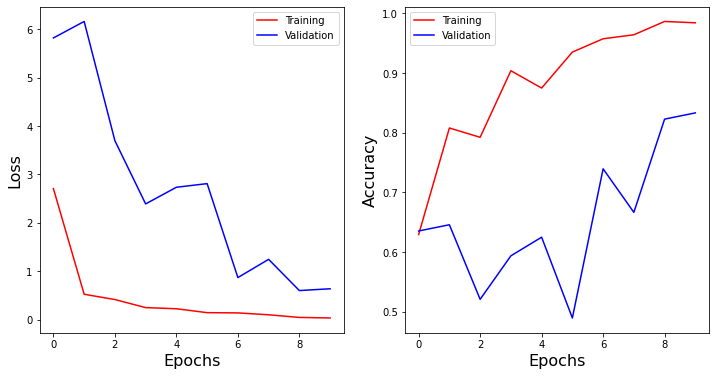

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

In [33]:
# Geting the model prediction
y_pred = model.predict(val_gen)
y_pred = (y_pred > 0.5).astype(int)

# Getting ideal values
y_true = []

for _, label in val_gen:        
    y_true.extend(label)
    
y_true = np.array(y_true, dtype='int')

In [38]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

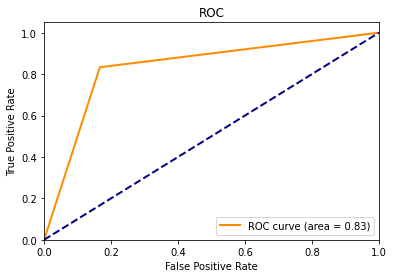

In [39]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

-------------------------------------------

## New data pipeline

Let's try another data pipeline, based on code from [keras.io](https://keras.io/api/preprocessing/image/)

In [ ]:
covid_dir = "CT_COVID/"
noncovid_dir = "CT_NonCOVID/"

img_size = (160, 160)

img_paths_covid = sorted(
        [
        os.path.join(covid_dir, fname)
        for fname in os.listdir(covid_dir)
        if fname.endswith(".png")
        ])

img_paths_noncovid = sorted(
        [
        os.path.join(noncovid_dir, fname)
        for fname in os.listdir(noncovid_dir)
        if fname.endswith(".png")
        ])


print(f"Number of samples with COVID: {len(img_paths_covid)}")
print(f"Number of samples without COVID: {len(img_paths_noncovid)}")

# Merging all data
all_paths = img_paths_covid + img_paths_noncovid
print(f"Number of total samples: {len(all_paths)}")

Number of samples with COVID: 349
Number of samples without COVID: 195
Number of total samples: 544


In [ ]:
import random

random.Random(42).shuffle(img_paths_covid)
random.Random(42).shuffle(img_paths_noncovid)

validation_split = 0.1
val_samples_covid = int(validation_split*len(img_paths_covid))

paths_covid_train = img_paths_covid[val_samples_covid:] 
paths_covid_test = img_paths_covid[:val_samples_covid] 

validation_split = 0.1
val_samples_noncovid = int(validation_split*len(img_paths_noncovid))

paths_noncovid_train = img_paths_noncovid[val_samples_noncovid:] 
paths_noncovid_test = img_paths_noncovid[:val_samples_noncovid] 

In [ ]:
import shutil

def move_data(file_path, move_path):
  """ Move data from file_path to move_path and keeps the same name.

  Parameters:
    file_path (list): Paths of files that you want to move.
    move_path (string): Destination that you want to move, 
                        without the final '/'.

  """
  for path in file_path:      
    shutil.move(path, move_path + '/' + path.split('/')[-1])


def make_dirs():
  """ Create directories for the covid dataset.
  
  """
  for path in ['covid', 'noncovid']:
    os.makedirs('data/train' + '/' + path )
  for path in ['covid', 'noncovid']:
    os.makedirs('data/test' + '/' + path )  

try:
  make_dirs()
except:
  pass

move_data(paths_covid_train, 'data/train/covid')
move_data(paths_covid_test, 'data/test/covid')
move_data(paths_noncovid_train, 'data/train/noncovid')
move_data(paths_noncovid_test, 'data/test/noncovid')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
print("Training dataset:")
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=img_size, 
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

print("Test dataset:")
test_generator = test_datagen.flow_from_directory(
        'data/test',  # this is the target directory
        target_size= img_size,
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

Training dataset:
Found 491 images belonging to 2 classes.
Test dataset:
Found 53 images belonging to 2 classes.


In [ ]:
model = resnet(img_size)
model.compile(optimizer = "adam", loss = "binary_crossentropy", 
              metrics = ["accuracy"])

In [ ]:
history = model.fit(train_generator,
                    # steps_per_epoch= 400 // batch_size,
                    epochs=10,
                    validation_data=test_generator,
                    # validation_steps=50 // batch_size,
                    )

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

### Evaluating the ROC curve

In [ ]:
# Geting the model prediction
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Getting ideal values
y_true = test_generator.classes

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()